In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from sklearn.metrics import roc_auc_score
# import riiideducation
# from tqdm import tqdm

In [61]:
# 한글 깨짐 방지 코드
import matplotlib
from matplotlib import font_manager, rc
import platform
if platform.system()=="Windows":
    font_name=font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus']=False

import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
'''
question == 문제
tag = 해설지(코드)
tags = 비슷한 것 끼리 묶은 것들

train.csv

row_id: (int64) ID code for the row.

timestamp: (int64) the time in milliseconds between this user interaction and the first event completion from that user.

user_id: (int32) ID code for the user.

content_id: (int16) ID code for the user interaction

content_type_id: (int8) 0 if the event was a question being posed to the user, 1 if the event was the user watching a lecture.

task_container_id: (int16) Id code for the batch of questions or lectures. 
For example, a user might see three questions in a row before seeing the explanations for any of them. 
Those three would all share a task_container_id.

user_answer: (int8) the user's answer to the question, if any. Read -1 as null, for lectures.

answered_correctly: (int8) if the user responded correctly. Read -1 as null, for lectures.

prior_question_elapsed_time: (float32) The average time in milliseconds it took a user to answer each question 
in the previous question bundle, ignoring any lectures in between. 
Is null for a user's first question bundle or lecture. 
Note that the time is the average time a user took to solve each question in the previous bundle.

prior_question_had_explanation: (bool) Whether or not the user saw an explanation and the correct response(s) 
after answering the previous question bundle, ignoring any lectures in between. 
The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. 
Typically the first several questions a user sees were part of an onboarding diagnostic test 
where they did not get any feedback.



questions.csv: metadata for the questions posed to users.

question_id: foreign key for the train/test content_id column, when the content type is question (0).

bundle_id: code for which questions are served together.

correct_answer: the answer to the question. Can be compared with the train user_answer column to check if the user was right.

part: the relevant section of the TOEIC test.

tags: one or more detailed tag codes for the question. The meaning of the tags will not be provided, but these codes are sufficient for clustering the questions together.



lectures.csv: metadata for the lectures watched by users as they progress in their education.

lecture_id: foreign key for the train/test content_id column, when the content type is lecture (1).

part: top level category code for the lecture.

tag: one tag codes for the lecture. The meaning of the tags will not be provided, but these codes are sufficient for clustering the lectures together.

type_of: brief description of the core purpose of the lecture



example_test_rows.csv Three sample groups of the test set data as it will be delivered by the time-series API. The format is largely the same as train.csv. There are two different columns that mirror what information the AI tutor actually has available at any given time, but with the user interactions grouped together for the sake of API performance rather than strictly showing information for a single user at a time. Some users will appear in the hidden test set that have NOT been presented in the train set, emulating the challenge of quickly adapting to modeling new arrivals to a website.

prior_group_responses (string) provides all of the user_answer entries for previous group in a string representation of a list in the first row of the group. All other rows in each group are null. If you are using Python, you will likely want to call eval on the non-null rows. Some rows may be null, or empty lists.

prior_group_answers_correct (string) provides all the answered_correctly field for previous group, with the same format and caveats as prior_group_responses. Some rows may be null, or empty lists.
'''

"\nquestion == 문제\ntag = 해설지(코드)\ntags = 비슷한 것 끼리 묶은 것들\n\ntrain.csv\n\nrow_id: (int64) ID code for the row.\n\ntimestamp: (int64) the time in milliseconds between this user interaction and the first event completion from that user.\n\nuser_id: (int32) ID code for the user.\n\ncontent_id: (int16) ID code for the user interaction\n\ncontent_type_id: (int8) 0 if the event was a question being posed to the user, 1 if the event was the user watching a lecture.\n\ntask_container_id: (int16) Id code for the batch of questions or lectures. \nFor example, a user might see three questions in a row before seeing the explanations for any of them. \nThose three would all share a task_container_id.\n\nuser_answer: (int8) the user's answer to the question, if any. Read -1 as null, for lectures.\n\nanswered_correctly: (int8) if the user responded correctly. Read -1 as null, for lectures.\n\nprior_question_elapsed_time: (float32) The average time in milliseconds it took a user to answer each question 

In [4]:
train = pd.read_csv('F:/data/riiid-test-answer-prediction/train.csv', nrows=10**4)
test = pd.read_csv("F:/data/riiid-test-answer-prediction/example_test.csv")
lectures = pd.read_csv("F:/data/riiid-test-answer-prediction/lectures.csv")
questions = pd.read_csv("F:/data/riiid-test-answer-prediction/questions.csv")

In [5]:
train

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,NaN
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False
...,...,...,...,...,...,...,...,...,...,...
9995,9995,2868187305,91216,1124,0,775,0,0,18000.0,True
9996,9996,2868272689,91216,810,0,776,0,1,18000.0,True
9997,9997,2868367298,91216,1245,0,777,0,1,17000.0,True
9998,9998,2868439137,91216,711,0,778,3,1,17000.0,True


---

In [6]:
# 우리가 시도한 것
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   row_id                          10000 non-null  int64  
 1   timestamp                       10000 non-null  int64  
 2   user_id                         10000 non-null  int64  
 3   content_id                      10000 non-null  int64  
 4   content_type_id                 10000 non-null  int64  
 5   task_container_id               10000 non-null  int64  
 6   user_answer                     10000 non-null  int64  
 7   answered_correctly              10000 non-null  int64  
 8   prior_question_elapsed_time     9742 non-null   float64
 9   prior_question_had_explanation  9979 non-null   object 
dtypes: float64(1), int64(8), object(1)
memory usage: 781.4+ KB


In [7]:
train.columns

Index(['row_id', 'timestamp', 'user_id', 'content_id', 'content_type_id',
       'task_container_id', 'user_answer', 'answered_correctly',
       'prior_question_elapsed_time', 'prior_question_had_explanation'],
      dtype='object')

In [8]:
# timestamp : 수강권을 끊은 유저가 강의를 본 시간이나 문제를 푼 총 시간??
train[train.user_id == 91216][:30]

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
9053,9053,0,91216,7900,0,0,0,1,NaN,NaN
9054,9054,23540,91216,7876,0,1,2,0,20000.0,False
9055,9055,48745,91216,175,0,2,0,0,20000.0,False
9056,9056,67665,91216,1278,0,3,3,1,23000.0,False
9057,9057,161655,91216,2063,0,4,1,0,17000.0,False
9058,9058,161655,91216,2064,0,4,1,1,17000.0,False
9059,9059,161655,91216,2065,0,4,2,1,17000.0,False
9060,9060,264795,91216,3364,0,5,1,1,29666.0,False
9061,9061,264795,91216,3363,0,5,1,0,29666.0,False
9062,9062,264795,91216,3365,0,5,1,0,29666.0,False


In [9]:
train.user_id.unique()

array([  115,   124,  2746,  5382,  8623,  8701, 12741, 13134, 24418,
       24600, 32421, 40828, 44331, 45001, 46886, 50132, 51285, 53842,
       81002, 81429, 91216], dtype=int64)

In [10]:
train.user_id.nunique()

21

In [11]:
# content_id = lecture_id + question_id
train.content_id.unique()

array([ 5692,  5716,   128, ..., 26335,  8848,  1244], dtype=int64)

In [12]:
# 21명이 총 6576개의 lecture랑 question를 보았다.
train.content_id.nunique()

6576

In [13]:
# 0이면 바로 문제푼거고, 1이면 강의를 본거고
train.content_type_id.value_counts()

0    9763
1     237
Name: content_type_id, dtype: int64

In [14]:
# task_container_id: (int16) Id code for the batch of questions or lectures. 
# For example, a user might see three questions in a row before seeing the explanations for any of them. 
# Those three would all share a task_container_id.

# task_container_id는 문제 타입의 갯수 (누적)


train[train.user_id == 124]

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
46,46,0,124,7900,0,0,0,1,NaN,NaN
47,47,32683,124,7876,0,1,0,0,26000.0,False
48,48,62000,124,175,0,2,2,1,29000.0,False
49,49,83632,124,1278,0,3,1,0,26000.0,False
50,50,189483,124,2064,0,4,2,0,18000.0,False
51,51,189483,124,2063,0,4,3,0,18000.0,False
52,52,189483,124,2065,0,4,2,1,18000.0,False
53,53,258793,124,3364,0,5,2,0,33333.0,False
54,54,258793,124,3365,0,5,3,0,33333.0,False
55,55,258793,124,3363,0,5,0,0,33333.0,False


In [15]:
# 보기는 0,1,2,3 인데 -1은 강의를 본 것
train.user_answer.unique()

array([ 3,  2,  0,  1, -1], dtype=int64)

In [16]:
train.user_answer.value_counts()

 0    2719
 1    2715
 3    2602
 2    1727
-1     237
Name: user_answer, dtype: int64

In [17]:
# 1은 정답을 맞힌 것, 0은 오답을 낸 것, -1은 강의를 본 것 
train.answered_correctly.value_counts()

 1    6578
 0    3185
-1     237
Name: answered_correctly, dtype: int64

In [18]:
# 이전에 문제를 푼 경과 시간. 만약에 문제가 세트로 나오면 그 문제들의 평균 시간
train.prior_question_elapsed_time

0           NaN
1       37000.0
2       55000.0
3       19000.0
4       11000.0
         ...   
9995    18000.0
9996    18000.0
9997    17000.0
9998    17000.0
9999    16000.0
Name: prior_question_elapsed_time, Length: 10000, dtype: float64

In [19]:
# 이전의 문제 묶음을 푼 후, 해설지나 정답을 봤으면 True, 어떤 경우에든 안 봤으면 False
train.prior_question_had_explanation.value_counts()

True     9330
False     649
Name: prior_question_had_explanation, dtype: int64

---

In [35]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   row_id                          10000 non-null  int64  
 1   timestamp                       10000 non-null  int64  
 2   user_id                         10000 non-null  int64  
 3   content_id                      10000 non-null  int64  
 4   content_type_id                 10000 non-null  int64  
 5   task_container_id               10000 non-null  int64  
 6   user_answer                     10000 non-null  int64  
 7   answered_correctly              10000 non-null  int64  
 8   prior_question_elapsed_time     9742 non-null   float64
 9   prior_question_had_explanation  9979 non-null   boolean
dtypes: boolean(1), float64(1), int64(8)
memory usage: 722.8 KB


In [36]:
# 코드 이해
train['prior_question_had_explanation'] = train['prior_question_had_explanation'].astype('boolean')

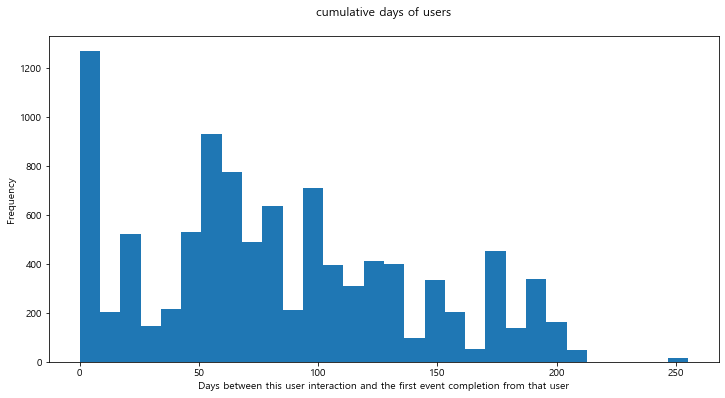

In [93]:
#1 year = 31536000000 ms
# 1s = 1000ms
# 1ms = 1/1000 s
# 60s = 1 min
# 60 min = 1 hr
# 1 day = 24hr
# 1 month = 30 * 24 * 60 * 60 * 1000 ms
# 1 year = 365 day = 365 * 24 hr 
# 1 year = 365 * 24 * 30 * 60 * 60 * 1000 ms
ts = train['timestamp']/(24 * 60 * 60 * 1000) # timestamp가 ms 단위인데 day로 환산
plt.figure(figsize=(12,6))
ts.plot.hist(bins=30)
plt.title('cumulative days of users', pad=20)
plt.xlabel('Days between this user interaction and the first event completion from that user')

plt.show()

# 해야 될 것 : 각각 사용자의 일수를 가져오는 전처리 작업 필요 


In [67]:
train.user_id.nunique()

21

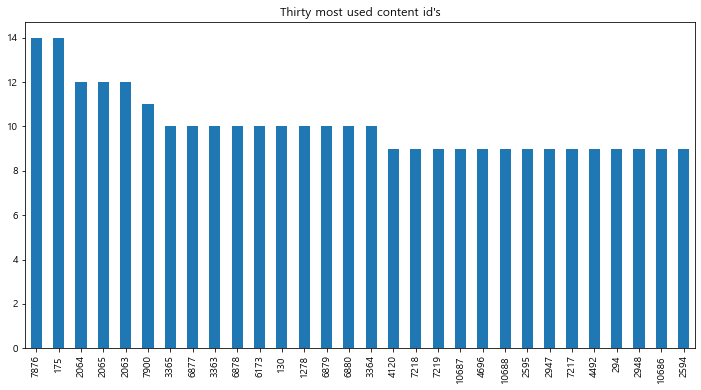

In [92]:
cids = train.content_id.value_counts()[:30]

plt.figure(figsize=(12,6))
cids.plot.bar()
plt.title("Thirty most used content id's")

# ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))s
plt.show()

In [94]:
train.content_type_id.value_counts()

0    9763
1     237
Name: content_type_id, dtype: int64

<AxesSubplot:ylabel='user_answer'>

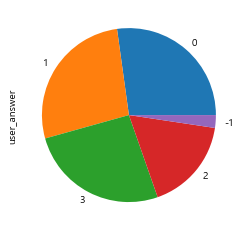

In [96]:
user_answer = train.user_answer.value_counts()
user_answer.plot.pie()
# 수정 필요 (수치라던가, 제목이라던가)

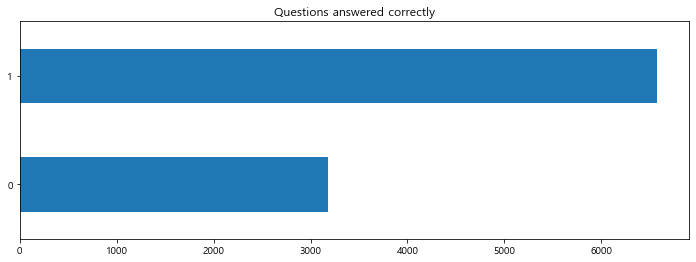

In [110]:
correct = train[train.answered_correctly != -1].answered_correctly.value_counts(ascending=True)

plt.figure(figsize=(12,4))
correct.plot.barh()
# for i, v in zip(correct.index, correct.values):
    # plt.text(v, i, '{:,}'.format(v), color='white', fontweight='bold', fontsize=14, ha='right', va='center')
plt.title("Questions answered correctly")
plt.show()

In [190]:
train[train.answered_correctly != -1].groupby('answered_correctly').size()
# train.pivot()

answered_correctly
0    3185
1    6578
dtype: int64

In [182]:
user_percent = train[train.answered_correctly != -1].groupby('user_id').answered_correctly.agg(Mean='mean', Answers='count')

In [183]:
user_percent[:15]

,Mean,Answers
user_id,,
115,0.695652,46
124,0.233333,30
2746,0.578947,19
5382,0.672000,125
8623,0.642202,109
8701,0.588235,17
12741,0.573585,265
13134,0.706356,1243
24418,0.690275,6283


In [184]:
user_percent.Answers.max()

6283

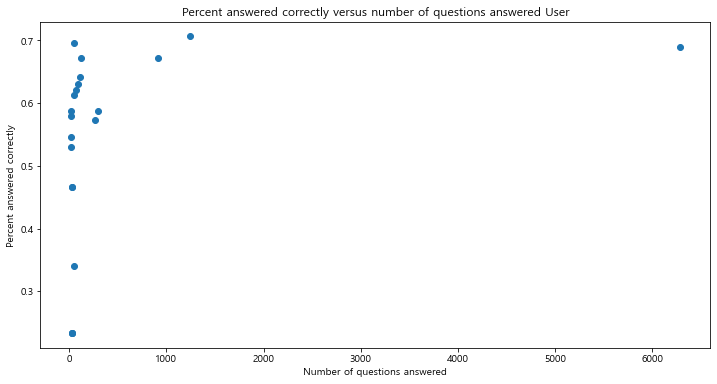

In [185]:
plt.figure(figsize=(12,6))
x = user_percent.Answers
y = user_percent.Mean
plt.scatter(x, y, marker='o')
plt.title("Percent answered correctly versus number of questions answered User")
plt.xlabel("Number of questions answered")
plt.ylabel("Percent answered correctly")

#  = np.polyfit(x, y, 1)
#  = np.poly1d(z)
# lt.plot(x,p(x),"r--")
plt.show()

In [186]:
content_percent = train[train.answered_correctly != -1].groupby('content_id').answered_correctly.agg(Mean='mean', Answers='count')

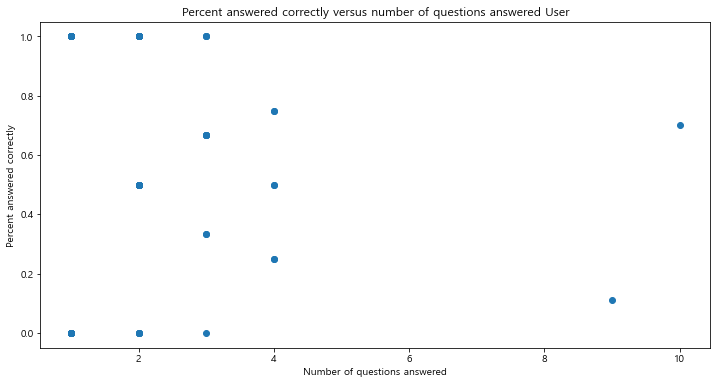

In [187]:
content_percent = content_percent.query('Answers <= 25000').sample(n=200, random_state=1) # 이해 필요

plt.figure(figsize=(12,6))
x1 = content_percent.Answers
y1 = content_percent.Mean
plt.scatter(x1, y1, marker='o')
plt.title("Percent answered correctly versus number of questions answered Content")
plt.xlabel("Number of questions answered")
plt.ylabel("Percent answered correctly")

#  = np.polyfit(x, y, 1)
#  = np.poly1d(z)
# lt.plot(x,p(x),"r--")
plt.show()


In [160]:
pqet = train[train.answered_correctly != -1]
pqet = pqet[['prior_question_elapsed_time', 'answered_correctly']]
pqet = pqet.groupby('answered_correctly').agg({'answered_correctly': 'count', 'prior_question_elapsed_time': 'mean' })

pqet

,answered_correctly,prior_question_elapsed_time
answered_correctly,,
0,3185,22086.292322
1,6578,22083.626904


In [167]:
# 하나 푸는데 걸리는 평균 초
pqet.iloc[:,1] / 1000

answered_correctly
0    22.086292
1    22.083627
Name: prior_question_elapsed_time, dtype: float64

In [112]:
train.prior_question_had_explanation

0        <NA>
1       False
2       False
3       False
4       False
        ...  
9995     True
9996     True
9997     True
9998     True
9999     True
Name: prior_question_had_explanation, Length: 10000, dtype: boolean

In [164]:
# 여러개의 함수를 여러 열에 적용 : agg()함수
# 모든열에 여러 함수를 매핑 : group객체.agg([함수1,함수2,함수3,…])
# 각 열마다 다른 함수를 매핑 : group객체.agg({‘열1’: 함수1, ‘열2’:함수2, …})

pqhe =train[train.answered_correctly != -1].groupby(['prior_question_had_explanation'], dropna=False).agg({'answered_correctly': ['mean', 'count']}) ;pq

prior_question_had_explanation
False    0.422330
True     0.684887
NaN      0.666667
Name: (answered_correctly, mean), dtype: float64

In [165]:
pqhe = pqhe.iloc[:,0]

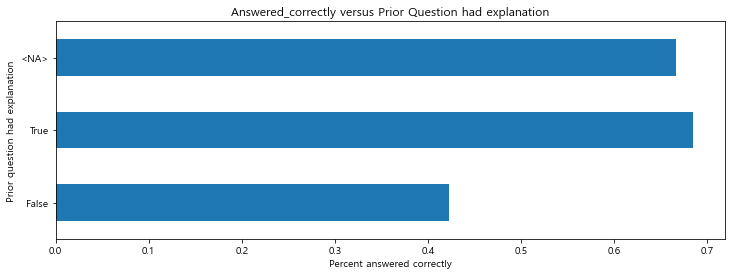

In [166]:
plt.figure(figsize=(12,4))
pqhe.plot.barh()
plt.title("Answered_correctly versus Prior Question had explanation")
plt.xlabel("Percent answered correctly")
plt.ylabel("Prior question had explanation")
plt.show()

---